In [1]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
#import visualkeras

from sklearn.model_selection import train_test_split

In [3]:
data_dir = (r'/kaggle/input/brain-tumor-classification-mri/Training/')
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))   

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor'

In [ ]:
plt.imshow(img_array)

Original shape of the images in the repository:

In [ ]:
img_array.shape

The size will be reduced in order to speed up the model processing:

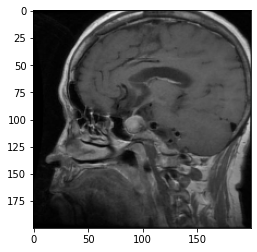

In [6]:
new_size = 200
new_array = cv2.resize(img_array,(new_size,new_size))    
plt.imshow(new_array,cmap = "gray")

The following will show one sample of each category in the repository:

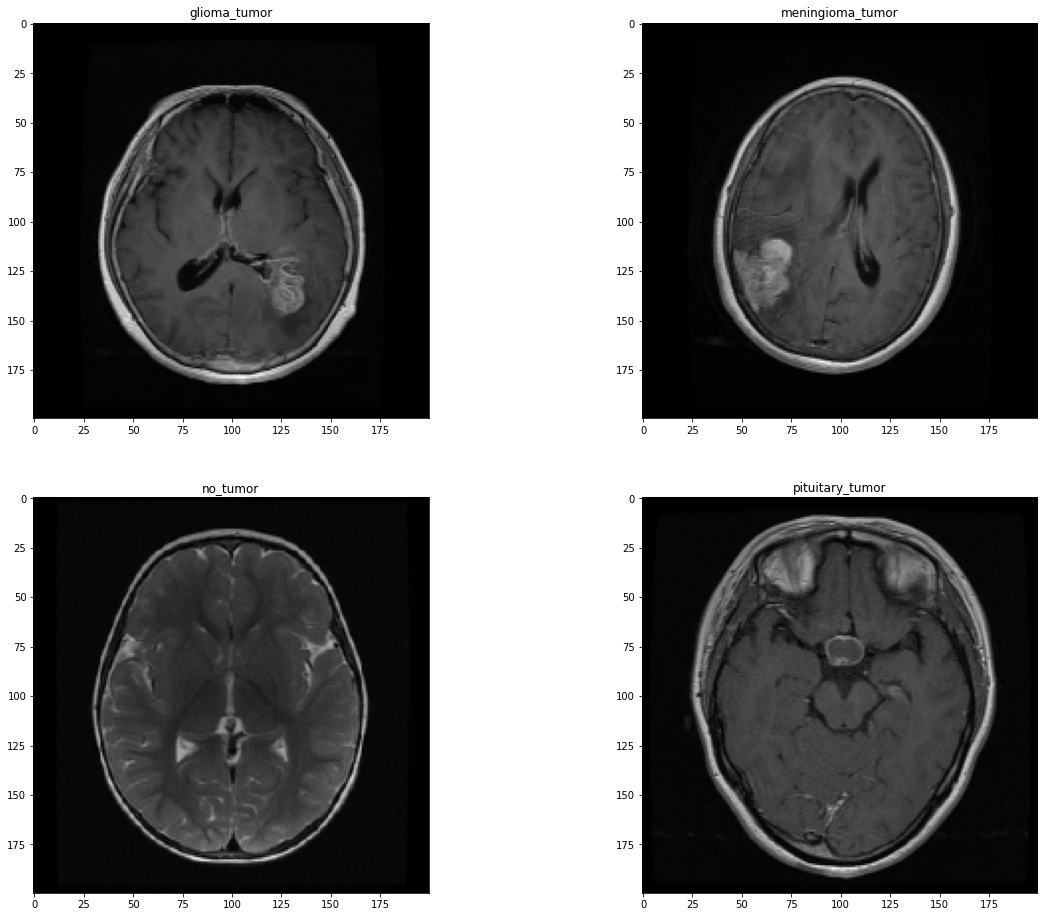

In [7]:
plt.figure(figsize=(20, 16))

fileNames = ['glioma_tumor/gg (10).jpg', 'meningioma_tumor/m (108).jpg', 'no_tumor/image (16).jpg', 'pituitary_tumor/p (12).jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + fileNames[i])
    img = cv2.resize(img, (new_size, new_size))
    plt.imshow(img)
    plt.title(categories[i])

Below we will Define the training sets as following:   
Grayscale images from training folder as x_train and its corresponding categories as y_train.

In [8]:
x_train=[]
y_train=[]

for i in categories:
    train_path = os.path.join(data_dir,i)
    for j in os.listdir(train_path):
        img = cv2.imread(os.path.join(train_path,j),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(new_size,new_size))
        x_train.append(img)
        y_train.append(i)

Normalizing and reshape of images to be suit for modeling:

In [9]:
x_train=np.array(x_train)
x_train=x_train/255.0
x_train = x_train.reshape(-1,new_size,new_size,1)
x_train.shape

(2870, 200, 200, 1)

In [10]:
y_train = np.array(y_train)
y_train.shape

(2870,)

Bar plot showing how many records are in each category inside training folder:

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

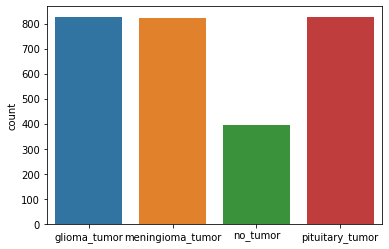

In [11]:
sns.countplot(y_train)

Splitting into training and validation sets at 20%:

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

In [13]:
import tensorflow as tf

Transform our multiclass label to one hot encode type:

In [14]:
y_train_new = []
for i in y_train:
    y_train_new.append(categories.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_val_new = []
for i in y_val:
    y_val_new.append(categories.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

Finally print the shape of the four sets, here we can see how the y_train and y_val contains 4 columns which represent the classes encoded:

In [15]:
X_train.shape, y_train.shape

((2296, 200, 200, 1), (2296, 4))

In [16]:
X_val.shape, y_val.shape

((574, 200, 200, 1), (574, 4))

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop,Adam,SGD,Adadelta
from keras.preprocessing.image import ImageDataGenerator

Let's define the number of epochs and batch size that the firsts models will have:

In [18]:
epochs = 30 
batch_size = 32

In [19]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    zoom_range = 0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=True,
    vertical_flip=False)  

## 1st comparison, non-regularized vs regularized model:

The following model is non-regularized and its layers will be used for the rest of the project:

In [20]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'Same', activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, padding= 'Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, padding= 'Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, padding= 'Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=512, kernel_size=3, padding= 'Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation = "relu"))

model.add(Dense(512, activation = "relu"))

model.add(Dense(4, activation = "softmax"))
optimizer = SGD(lr=0.01)

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [21]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
72/72 [==============================] - 12s 73ms/step - loss: 1.3762 - accuracy: 0.3325 - val_loss: 1.3528 - val_accuracy: 0.4094
Epoch 2/30
72/72 [==============================] - 4s 55ms/step - loss: 1.3574 - accuracy: 0.4169 - val_loss: 1.3337 - val_accuracy: 0.4443
Epoch 3/30
72/72 [==============================] - 4s 50ms/step - loss: 1.3326 - accuracy: 0.4640 - val_loss: 1.3142 - val_accuracy: 0.4530
Epoch 4/30
72/72 [==============================] - 4s 51ms/step - loss: 1.3225 - accuracy: 0.4836 - val_loss: 1.2690 - val_accuracy: 0.4721
Epoch 5/30
72/72 [==============================] - 4s 52ms/step - loss: 1.2497 - accuracy: 0.4995 - val_loss: 1.1288 - val_accuracy: 0.5383
Epoch 6/30
72/72 [==============================] - 4s 51ms/step - loss: 1.1481 - accuracy: 0.4860 - val_loss: 1.0679 - val_accuracy: 0.5122
Epoch 7/30
72/72 [==============================] - 4s 50ms/step - loss: 1.0469 - accuracy: 0.5467 - val_loss: 0.9702 - val_accuracy: 0.6010
Epoch 8/30
7

Regularized model using Batch Normalization for Convolutional layers and Dropout for Fully conected layers:

In [22]:
model1 = Sequential()
model1.add(Conv2D(filters=64, kernel_size=3, padding= 'Same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=128, kernel_size=3, padding= 'Same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=128, kernel_size=3, padding= 'Same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=256, kernel_size=3, padding= 'Same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=256, kernel_size=3, padding= 'Same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=512, kernel_size=3, padding= 'Same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(BatchNormalization())

model1.add(Flatten())
model1.add(Dense(1024, activation = "relu"))
model1.add(Dropout(0.2))

model1.add(Dense(512, activation = "relu"))
model1.add(Dropout(0.2))

model1.add(Dense(4, activation = "softmax"))
optimizer = SGD(lr=0.01)

model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
history1 = model1.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (X_val,y_val))

Epoch 1/30
72/72 [==============================] - 5s 60ms/step - loss: 1.2552 - accuracy: 0.5361 - val_loss: 1.7946 - val_accuracy: 0.2718
Epoch 2/30
72/72 [==============================] - 4s 54ms/step - loss: 0.5853 - accuracy: 0.7630 - val_loss: 2.5908 - val_accuracy: 0.1394
Epoch 3/30
72/72 [==============================] - 4s 54ms/step - loss: 0.4699 - accuracy: 0.8030 - val_loss: 3.1785 - val_accuracy: 0.2718
Epoch 4/30
72/72 [==============================] - 4s 56ms/step - loss: 0.3563 - accuracy: 0.8536 - val_loss: 4.0249 - val_accuracy: 0.2718
Epoch 5/30
72/72 [==============================] - 4s 55ms/step - loss: 0.2765 - accuracy: 0.8912 - val_loss: 3.3761 - val_accuracy: 0.2997
Epoch 6/30
72/72 [==============================] - 4s 56ms/step - loss: 0.2168 - accuracy: 0.9181 - val_loss: 2.5410 - val_accuracy: 0.3275
Epoch 7/30
72/72 [==============================] - 4s 55ms/step - loss: 0.1702 - accuracy: 0.9375 - val_loss: 1.2407 - val_accuracy: 0.5052
Epoch 8/30
72

### Plotting Loss and Accuracy for both models: 

Text(0.5, 1.0, 'Accuracy regularized model')

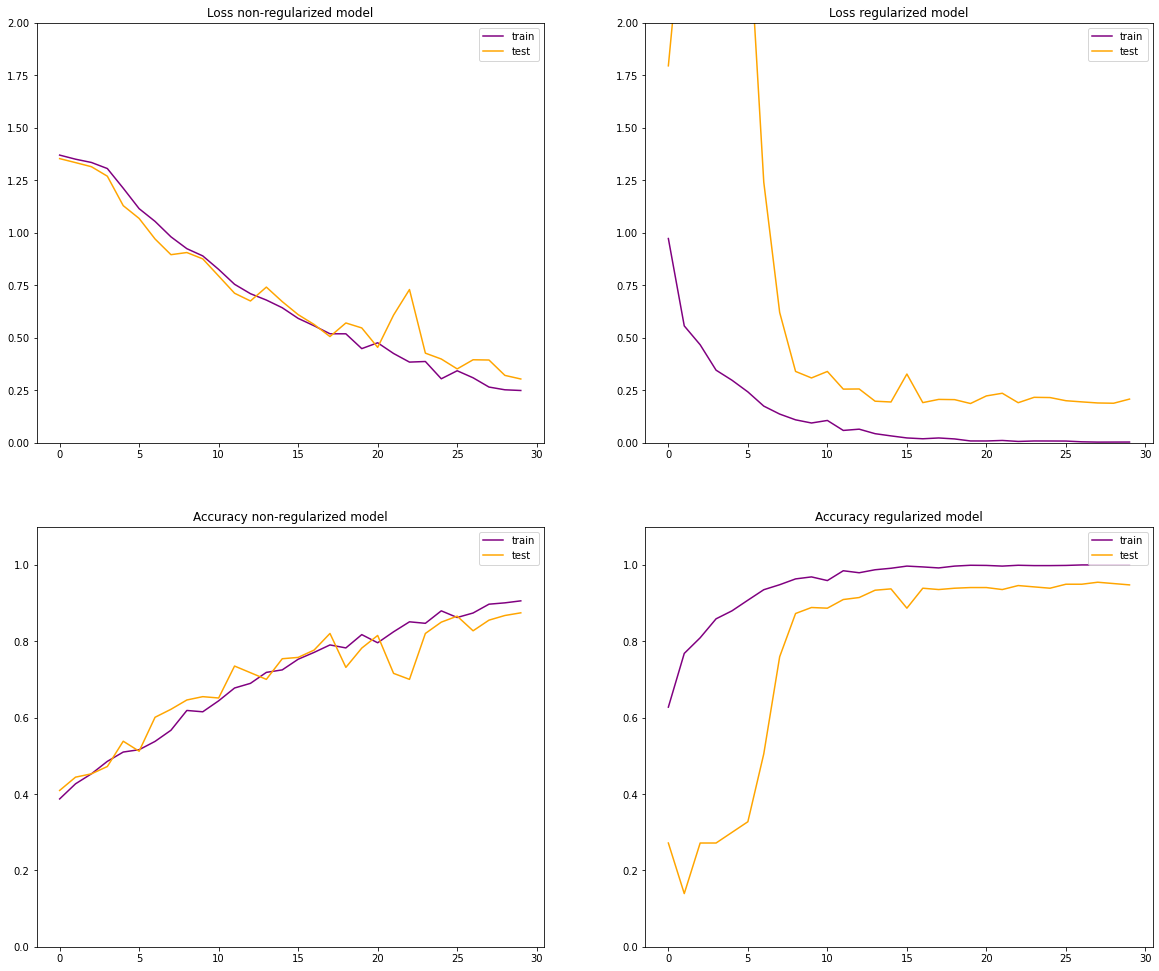

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(20,17))

axs[0, 0].plot(history.history["loss"],c = "purple")
axs[0, 0].plot(history.history["val_loss"],c = "orange")
axs[0, 0].set_ylim([0,2])
axs[0, 0].legend(["train", "test"])
axs[0, 0].set_title('Loss non-regularized model')

axs[0, 1].plot(history1.history["loss"],c = "purple")
axs[0, 1].plot(history1.history["val_loss"],c = "orange")
axs[0, 1].set_ylim([0,2])
axs[0, 1].legend(["train", "test"])
axs[0, 1].set_title('Loss regularized model')

axs[1, 0].plot(history.history["accuracy"],c = "purple")
axs[1, 0].plot(history.history["val_accuracy"],c = "orange")
axs[1, 0].set_ylim([0,1.1])
axs[1, 0].legend(["train", "test"])
axs[1, 0].set_title('Accuracy non-regularized model')

axs[1, 1].plot(history1.history["accuracy"],c = "purple")
axs[1, 1].plot(history1.history["val_accuracy"],c = "orange")
axs[1, 1].set_ylim([0,1.1])
axs[1, 1].legend(["train", "test"])
axs[1, 1].set_title('Accuracy regularized model')

**Insights:** The regularization had a positive effect by reducing the overfitting as can be seen, this lead to a better accuracy in both training and validation sets.

## 2nd comparison, Kernel size: 3x3, 5x5, 7x7:

Kernel 5x5: 

In [25]:
model2 = Sequential()
model2.add(Conv2D(filters=64, kernel_size=5, padding= 'Same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size=5, padding= 'Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size=5, padding= 'Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=256, kernel_size=5, padding= 'Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=256, kernel_size=5, padding= 'Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=512, kernel_size=5, padding= 'Same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.2))

model2.add(Dense(512, activation = "relu"))
model2.add(Dropout(0.2))

model2.add(Dense(4, activation = "softmax"))
optimizer = SGD(lr=0.01)

model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
history2 = model2.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (X_val,y_val))

Epoch 1/30
72/72 [==============================] - 8s 93ms/step - loss: 1.4249 - accuracy: 0.5293 - val_loss: 1.7318 - val_accuracy: 0.2718
Epoch 2/30
72/72 [==============================] - 5s 65ms/step - loss: 0.5924 - accuracy: 0.7522 - val_loss: 1.7906 - val_accuracy: 0.3153
Epoch 3/30
72/72 [==============================] - 5s 65ms/step - loss: 0.5093 - accuracy: 0.7984 - val_loss: 1.9922 - val_accuracy: 0.2979
Epoch 4/30
72/72 [==============================] - 5s 67ms/step - loss: 0.3592 - accuracy: 0.8410 - val_loss: 2.0856 - val_accuracy: 0.3275
Epoch 5/30
72/72 [==============================] - 5s 65ms/step - loss: 0.3068 - accuracy: 0.8746 - val_loss: 2.5718 - val_accuracy: 0.3432
Epoch 6/30
72/72 [==============================] - 5s 66ms/step - loss: 0.2322 - accuracy: 0.9096 - val_loss: 1.3033 - val_accuracy: 0.4808
Epoch 7/30
72/72 [==============================] - 5s 65ms/step - loss: 0.1886 - accuracy: 0.9251 - val_loss: 0.6240 - val_accuracy: 0.7578
Epoch 8/30
72

Kernel 7x7:

In [27]:
model3 = Sequential()
model3.add(Conv2D(filters=64, kernel_size=7, padding= 'Same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=128, kernel_size=7, padding= 'Same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=128, kernel_size=7, padding= 'Same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=256, kernel_size=7, padding= 'Same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=256, kernel_size=7, padding= 'Same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=512, kernel_size=7, padding= 'Same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())

model3.add(Flatten())
model3.add(Dense(1024, activation = "relu"))
model3.add(Dropout(0.2))

model3.add(Dense(512, activation = "relu"))
model3.add(Dropout(0.2))

model3.add(Dense(4, activation = "softmax"))
optimizer = SGD(lr=0.01)

model3.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [28]:
history3 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (X_val,y_val))

Epoch 1/30
72/72 [==============================] - 12s 133ms/step - loss: 1.5349 - accuracy: 0.5226 - val_loss: 1.6048 - val_accuracy: 0.2718
Epoch 2/30
72/72 [==============================] - 6s 87ms/step - loss: 0.6284 - accuracy: 0.7301 - val_loss: 1.6975 - val_accuracy: 0.2753
Epoch 3/30
72/72 [==============================] - 6s 88ms/step - loss: 0.5456 - accuracy: 0.7659 - val_loss: 2.3279 - val_accuracy: 0.3258
Epoch 4/30
72/72 [==============================] - 6s 89ms/step - loss: 0.3939 - accuracy: 0.8471 - val_loss: 1.2541 - val_accuracy: 0.4808
Epoch 5/30
72/72 [==============================] - 6s 88ms/step - loss: 0.2953 - accuracy: 0.8841 - val_loss: 1.1269 - val_accuracy: 0.5087
Epoch 6/30
72/72 [==============================] - 6s 87ms/step - loss: 0.2200 - accuracy: 0.9190 - val_loss: 0.5488 - val_accuracy: 0.7944
Epoch 7/30
72/72 [==============================] - 6s 88ms/step - loss: 0.2096 - accuracy: 0.9165 - val_loss: 0.3274 - val_accuracy: 0.8850
Epoch 8/30


Later we will see why I am saving this model:

In [29]:
from keras.models import load_model

model3.save('my_model.h5')

### Plotting Loss and Accuracy for the three models: 

Text(0.5, 1.0, 'Accuracy model kernels 7x7')

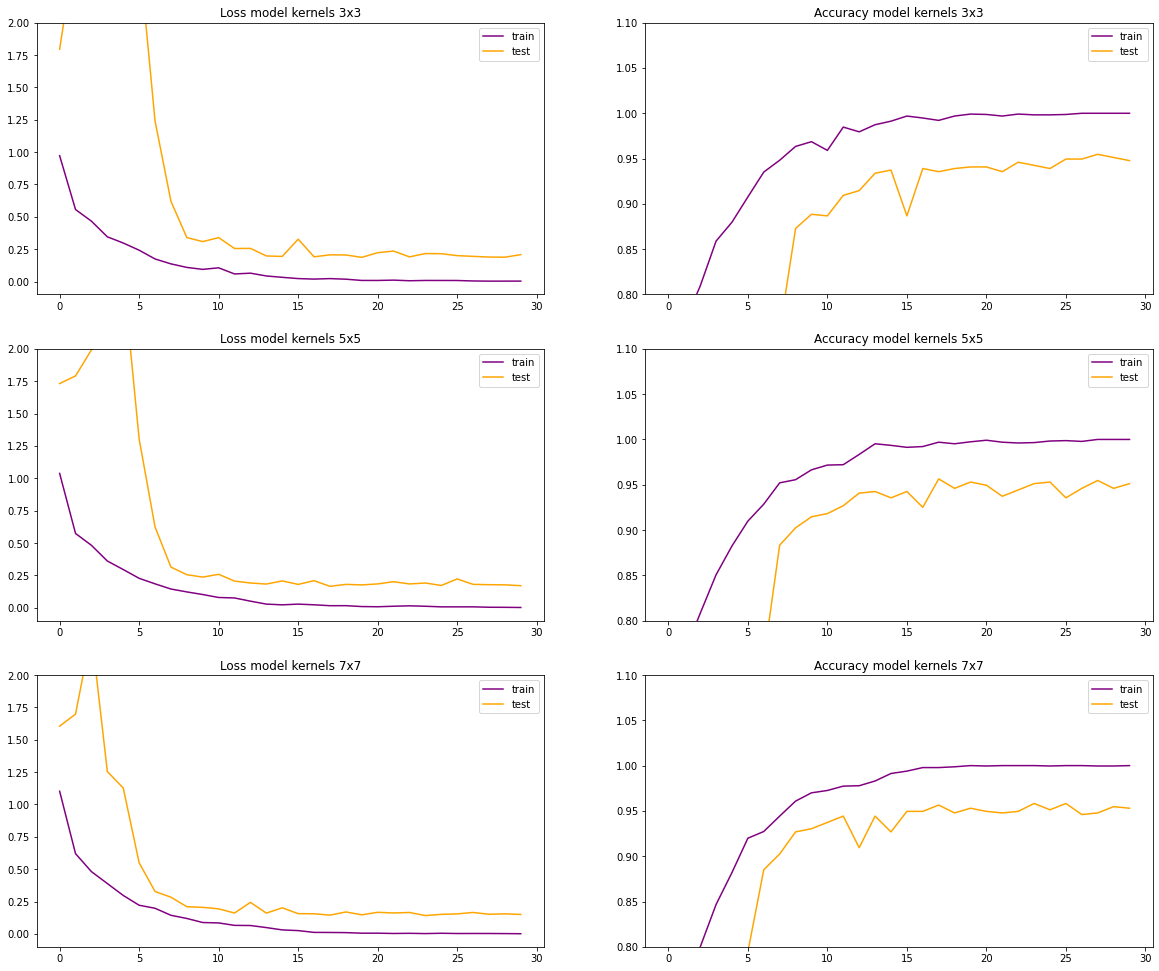

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(20,17))

axs[0, 0].plot(history1.history["loss"],c = "purple")
axs[0, 0].plot(history1.history["val_loss"],c = "orange")
axs[0, 0].set_ylim([-0.1,2])
axs[0, 0].legend(["train", "test"])
axs[0, 0].set_title('Loss model kernels 3x3')

axs[0, 1].plot(history1.history["accuracy"],c = "purple")
axs[0, 1].plot(history1.history["val_accuracy"],c = "orange")
axs[0, 1].set_ylim([0.8,1.1])
axs[0, 1].legend(["train", "test"])
axs[0, 1].set_title('Accuracy model kernels 3x3')

axs[1, 0].plot(history2.history["loss"],c = "purple")
axs[1, 0].plot(history2.history["val_loss"],c = "orange")
axs[1, 0].set_ylim([-0.1,2])
axs[1, 0].legend(["train", "test"])
axs[1, 0].set_title('Loss model kernels 5x5')

axs[1, 1].plot(history2.history["accuracy"],c = "purple")
axs[1, 1].plot(history2.history["val_accuracy"],c = "orange")
axs[1, 1].set_ylim([0.8,1.1])
axs[1, 1].legend(["train", "test"])
axs[1, 1].set_title('Accuracy model kernels 5x5')

axs[2, 0].plot(history3.history["loss"],c = "purple")
axs[2, 0].plot(history3.history["val_loss"],c = "orange")
axs[2, 0].set_ylim([-0.1,2])
axs[2, 0].legend(["train", "test"])
axs[2, 0].set_title('Loss model kernels 7x7')

axs[2, 1].plot(history3.history["accuracy"],c = "purple")
axs[2, 1].plot(history3.history["val_accuracy"],c = "orange")
axs[2, 1].set_ylim([0.8,1.1])
axs[2, 1].legend(["train", "test"])
axs[2, 1].set_title('Accuracy model kernels 7x7')

**Insights:** The three models had a flawless performance reaching validation accuracies over 95%, also we can see how by increasing the kernel size implies a softening of the validation curve (less transitions), despite the fact that there is not a huge difference between them kernel size 7x7 was chosen to continue for offering the highest accuracy and most stable curve.

## 3rd comparison, models with Batch size equal to 16, 32 or 64:

Batch size = 16:

In [31]:
history4 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=16),
                                epochs = epochs, validation_data = (X_val,y_val))

Epoch 1/30
144/144 [==============================] - 11s 67ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1756 - val_accuracy: 0.9512
Epoch 2/30
144/144 [==============================] - 9s 62ms/step - loss: 0.2417 - accuracy: 0.9155 - val_loss: 0.4851 - val_accuracy: 0.8362
Epoch 3/30
144/144 [==============================] - 9s 62ms/step - loss: 0.1715 - accuracy: 0.9364 - val_loss: 0.3642 - val_accuracy: 0.8780
Epoch 4/30
144/144 [==============================] - 9s 63ms/step - loss: 0.0968 - accuracy: 0.9682 - val_loss: 0.4215 - val_accuracy: 0.8815
Epoch 5/30
144/144 [==============================] - 9s 62ms/step - loss: 0.0642 - accuracy: 0.9813 - val_loss: 0.1588 - val_accuracy: 0.9530
Epoch 6/30
144/144 [==============================] - 9s 62ms/step - loss: 0.0589 - accuracy: 0.9765 - val_loss: 0.2164 - val_accuracy: 0.9286
Epoch 7/30
144/144 [==============================] - 9s 62ms/step - loss: 0.0501 - accuracy: 0.9852 - val_loss: 0.1673 - val_accuracy: 0.946

Batch size = 64:

In [32]:
history5 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=64),
                                epochs = epochs, validation_data = (X_val,y_val))

Epoch 1/30
36/36 [==============================] - 11s 218ms/step - loss: 9.5582e-04 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9617
Epoch 2/30
36/36 [==============================] - 5s 146ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1429 - val_accuracy: 0.9617
Epoch 3/30
36/36 [==============================] - 5s 145ms/step - loss: 5.2353e-04 - accuracy: 1.0000 - val_loss: 0.1430 - val_accuracy: 0.9652
Epoch 4/30
36/36 [==============================] - 5s 146ms/step - loss: 4.3533e-04 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 0.9634
Epoch 5/30
36/36 [==============================] - 5s 149ms/step - loss: 4.3439e-04 - accuracy: 1.0000 - val_loss: 0.1438 - val_accuracy: 0.9652
Epoch 6/30
36/36 [==============================] - 5s 150ms/step - loss: 5.0505e-04 - accuracy: 1.0000 - val_loss: 0.1399 - val_accuracy: 0.9669
Epoch 7/30
36/36 [==============================] - 5s 146ms/step - loss: 3.2597e-04 - accuracy: 1.0000 - val_loss: 0.1403 - va

### Plotting Loss and Accuracy for the three models:

Text(0.5, 1.0, 'Accuracy model batch size 64')

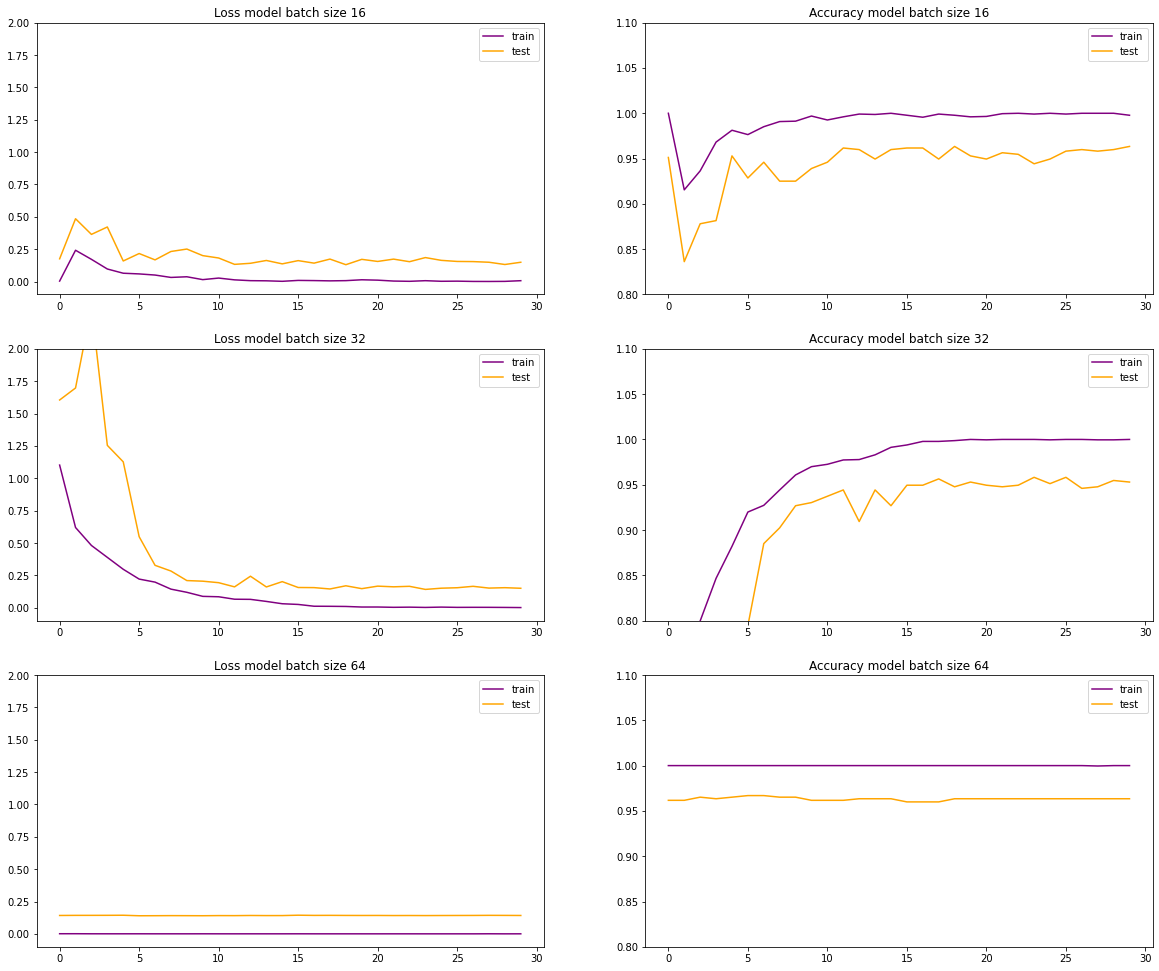

In [33]:
fig, axs = plt.subplots(3, 2, figsize=(20,17))

axs[0, 0].plot(history4.history["loss"],c = "purple")
axs[0, 0].plot(history4.history["val_loss"],c = "orange")
axs[0, 0].set_ylim([-0.1,2])
axs[0, 0].legend(["train", "test"])
axs[0, 0].set_title('Loss model batch size 16')

axs[0, 1].plot(history4.history["accuracy"],c = "purple")
axs[0, 1].plot(history4.history["val_accuracy"],c = "orange")
axs[0, 1].set_ylim([0.8,1.1])
axs[0, 1].legend(["train", "test"])
axs[0, 1].set_title('Accuracy model batch size 16')

axs[1, 0].plot(history3.history["loss"],c = "purple")
axs[1, 0].plot(history3.history["val_loss"],c = "orange")
axs[1, 0].set_ylim([-0.1,2])
axs[1, 0].legend(["train", "test"])
axs[1, 0].set_title('Loss model batch size 32')

axs[1, 1].plot(history3.history["accuracy"],c = "purple")
axs[1, 1].plot(history3.history["val_accuracy"],c = "orange")
axs[1, 1].set_ylim([0.8,1.1])
axs[1, 1].legend(["train", "test"])
axs[1, 1].set_title('Accuracy model batch size 32')

axs[2, 0].plot(history5.history["loss"],c = "purple")
axs[2, 0].plot(history5.history["val_loss"],c = "orange")
axs[2, 0].set_ylim([-0.1,2])
axs[2, 0].legend(["train", "test"])
axs[2, 0].set_title('Loss model batch size 64')

axs[2, 1].plot(history5.history["accuracy"],c = "purple")
axs[2, 1].plot(history5.history["val_accuracy"],c = "orange")
axs[2, 1].set_ylim([0.8,1.1])
axs[2, 1].legend(["train", "test"])
axs[2, 1].set_title('Accuracy model batch size 64')

**Insights:** Firstly, again there is not a significant difference between the accuracies in the lasts epochs for the models, but batch size=16 offers the lowest accuracy and batch size=64 seems very strange as looks like it's extremely overfitting because of its perfect accuracy since the very first epoch and the same happens with validation set being always 96%, which is evidence that something is not working properly. However batch size=32 looks much better by increasing gradually and stably its accuracy in both training and validation sets.  
**Note:** In the box comments I would love to know your ideas of why you think batch size=64 had such behaviour, I've researched a lot and didn't find enough. 

## 4th comparison, models with number of epochs equal to 30, 50 or 70:

Training model with 50 epochs:

In [34]:
history7 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                                epochs = 50, validation_data = (X_val,y_val))

Epoch 1/50
72/72 [==============================] - 6s 89ms/step - loss: 1.7916e-04 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9634
Epoch 2/50
72/72 [==============================] - 6s 86ms/step - loss: 2.4588e-04 - accuracy: 1.0000 - val_loss: 0.1413 - val_accuracy: 0.9617
Epoch 3/50
72/72 [==============================] - 6s 87ms/step - loss: 3.4862e-04 - accuracy: 1.0000 - val_loss: 0.1454 - val_accuracy: 0.9599
Epoch 4/50
72/72 [==============================] - 6s 87ms/step - loss: 3.6656e-04 - accuracy: 1.0000 - val_loss: 0.1447 - val_accuracy: 0.9634
Epoch 5/50
72/72 [==============================] - 6s 88ms/step - loss: 2.1611e-04 - accuracy: 1.0000 - val_loss: 0.1435 - val_accuracy: 0.9652
Epoch 6/50
72/72 [==============================] - 6s 88ms/step - loss: 2.5686e-04 - accuracy: 1.0000 - val_loss: 0.1435 - val_accuracy: 0.9617
Epoch 7/50
72/72 [==============================] - 6s 86ms/step - loss: 1.6348e-04 - accuracy: 1.0000 - val_loss: 0.1418 - val_ac

Training model with 70 epochs: 

In [35]:
history8 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                                epochs = 70, validation_data = (X_val,y_val))

Epoch 1/70
72/72 [==============================] - 6s 88ms/step - loss: 8.8332e-05 - accuracy: 1.0000 - val_loss: 0.1433 - val_accuracy: 0.9617
Epoch 2/70
72/72 [==============================] - 6s 87ms/step - loss: 8.8319e-05 - accuracy: 1.0000 - val_loss: 0.1430 - val_accuracy: 0.9617
Epoch 3/70
72/72 [==============================] - 6s 86ms/step - loss: 6.7730e-05 - accuracy: 1.0000 - val_loss: 0.1434 - val_accuracy: 0.9617
Epoch 4/70
72/72 [==============================] - 6s 86ms/step - loss: 8.7844e-05 - accuracy: 1.0000 - val_loss: 0.1421 - val_accuracy: 0.9617
Epoch 5/70
72/72 [==============================] - 6s 86ms/step - loss: 1.1634e-04 - accuracy: 1.0000 - val_loss: 0.1424 - val_accuracy: 0.9617
Epoch 6/70
72/72 [==============================] - 6s 89ms/step - loss: 9.7738e-05 - accuracy: 1.0000 - val_loss: 0.1422 - val_accuracy: 0.9617
Epoch 7/70
72/72 [==============================] - 6s 87ms/step - loss: 9.2996e-05 - accuracy: 1.0000 - val_loss: 0.1425 - val_ac

### Plotting Loss and Accuracy for the three models: 

Text(0.5, 1.0, 'Accuracy model b32 70 epochs')

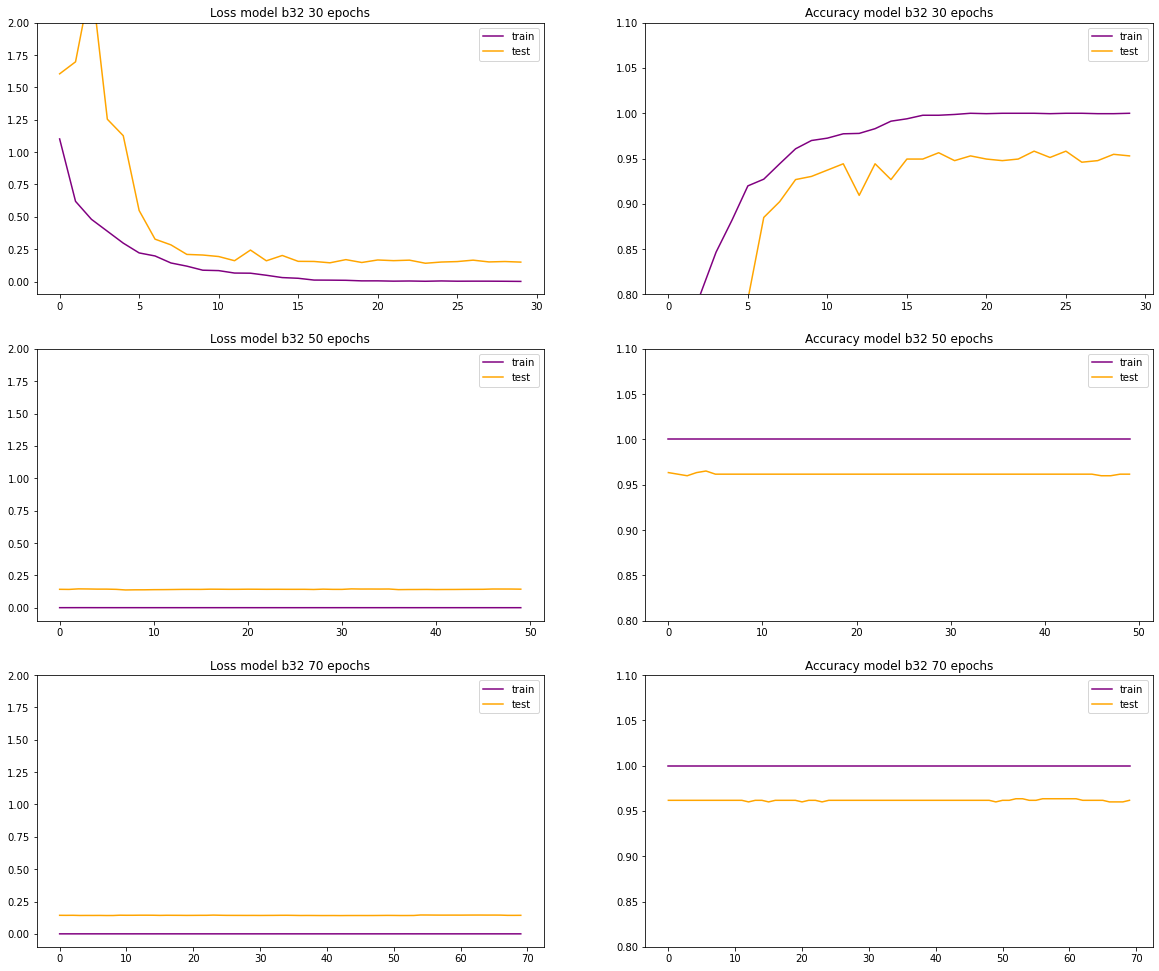

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(20,17))

axs[0, 0].plot(history3.history["loss"],c = "purple")
axs[0, 0].plot(history3.history["val_loss"],c = "orange")
axs[0, 0].set_ylim([-0.1,2])
axs[0, 0].legend(["train", "test"])
axs[0, 0].set_title('Loss model b32 30 epochs')

axs[0, 1].plot(history3.history["accuracy"],c = "purple")
axs[0, 1].plot(history3.history["val_accuracy"],c = "orange")
axs[0, 1].set_ylim([0.8,1.1])
axs[0, 1].legend(["train", "test"])
axs[0, 1].set_title('Accuracy model b32 30 epochs')

axs[1, 0].plot(history7.history["loss"],c = "purple")
axs[1, 0].plot(history7.history["val_loss"],c = "orange")
axs[1, 0].set_ylim([-0.1,2])
axs[1, 0].legend(["train", "test"])
axs[1, 0].set_title('Loss model b32 50 epochs')

axs[1, 1].plot(history7.history["accuracy"],c = "purple")
axs[1, 1].plot(history7.history["val_accuracy"],c = "orange")
axs[1, 1].set_ylim([0.8,1.1])
axs[1, 1].legend(["train", "test"])
axs[1, 1].set_title('Accuracy model b32 50 epochs')

axs[2, 0].plot(history8.history["loss"],c = "purple")
axs[2, 0].plot(history8.history["val_loss"],c = "orange")
axs[2, 0].set_ylim([-0.1,2])
axs[2, 0].legend(["train", "test"])
axs[2, 0].set_title('Loss model b32 70 epochs')

axs[2, 1].plot(history8.history["accuracy"],c = "purple")
axs[2, 1].plot(history8.history["val_accuracy"],c = "orange")
axs[2, 1].set_ylim([0.8,1.1])
axs[2, 1].legend(["train", "test"])
axs[2, 1].set_title('Accuracy model b32 70 epochs')

**Insights:** Clearly as we add more epochs above 30 there is not a difference, it is the same value, meaning the same performance with less training.  
Best number of epochs:30.  
Best number of batch size:32.

## 5th comparison, models using optimizers Adam, SGD, RMSProp, Adadelta:

In [37]:
#history3 was the best one until now and its characteristics were:
b_size=32
ep=30

In [38]:
optimizer1 = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
model3.compile(optimizer = optimizer1 , loss = "categorical_crossentropy", metrics=["accuracy"])
history9 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=b_size),
                                epochs = ep, validation_data = (X_val,y_val))

Epoch 1/30
72/72 [==============================] - 7s 92ms/step - loss: 33.2073 - accuracy: 0.4480 - val_loss: 551.9515 - val_accuracy: 0.1220
Epoch 2/30
72/72 [==============================] - 6s 87ms/step - loss: 1.1852 - accuracy: 0.5009 - val_loss: 10.1535 - val_accuracy: 0.1638
Epoch 3/30
72/72 [==============================] - 6s 87ms/step - loss: 1.1398 - accuracy: 0.5386 - val_loss: 1.4561 - val_accuracy: 0.4321
Epoch 4/30
72/72 [==============================] - 6s 88ms/step - loss: 1.1110 - accuracy: 0.5450 - val_loss: 1.0159 - val_accuracy: 0.6045
Epoch 5/30
72/72 [==============================] - 6s 86ms/step - loss: 1.1263 - accuracy: 0.5107 - val_loss: 0.9327 - val_accuracy: 0.6359
Epoch 6/30
72/72 [==============================] - 6s 87ms/step - loss: 1.1386 - accuracy: 0.5508 - val_loss: 1.0529 - val_accuracy: 0.5819
Epoch 7/30
72/72 [==============================] - 6s 87ms/step - loss: 1.1651 - accuracy: 0.5052 - val_loss: 1.0801 - val_accuracy: 0.5714
Epoch 8/3

In [39]:
optimizer2 = RMSprop(lr=0.01, rho=0.9)
model3.compile(optimizer = optimizer2 , loss = "categorical_crossentropy", metrics=["accuracy"])
history10 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=b_size),
                                 epochs = ep, validation_data = (X_val,y_val))

Epoch 1/30
72/72 [==============================] - 8s 94ms/step - loss: 1.9534 - accuracy: 0.2728 - val_loss: 1.3408 - val_accuracy: 0.2944
Epoch 2/30
72/72 [==============================] - 6s 90ms/step - loss: 1.3679 - accuracy: 0.2695 - val_loss: 126.7077 - val_accuracy: 0.4007
Epoch 3/30
72/72 [==============================] - 7s 90ms/step - loss: 1.3553 - accuracy: 0.2865 - val_loss: 1.3371 - val_accuracy: 0.2944
Epoch 4/30
72/72 [==============================] - 7s 91ms/step - loss: 1.4271 - accuracy: 0.2785 - val_loss: 1.3383 - val_accuracy: 0.2718
Epoch 5/30
72/72 [==============================] - 6s 90ms/step - loss: 2.0320 - accuracy: 0.2748 - val_loss: 1.3378 - val_accuracy: 0.2718
Epoch 6/30
72/72 [==============================] - 6s 90ms/step - loss: 1.3664 - accuracy: 0.2802 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 7/30
72/72 [==============================] - 6s 89ms/step - loss: 1.3492 - accuracy: 0.2874 - val_loss: 1.3380 - val_accuracy: 0.2718
Epoch 8/30


In [40]:
optimizer3 = Adadelta(lr=0.01, rho=0.95)
model3.compile(optimizer = optimizer3 , loss = "categorical_crossentropy", metrics=["accuracy"])
history11 = model3.fit_generator(datagen.flow(X_train,y_train, batch_size=b_size),
                                 epochs = ep, validation_data = (X_val,y_val))

Epoch 1/30
72/72 [==============================] - 7s 93ms/step - loss: 1.3581 - accuracy: 0.2950 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 2/30
72/72 [==============================] - 6s 87ms/step - loss: 1.3463 - accuracy: 0.2892 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 3/30
72/72 [==============================] - 6s 88ms/step - loss: 1.3669 - accuracy: 0.2808 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 4/30
72/72 [==============================] - 6s 88ms/step - loss: 1.3535 - accuracy: 0.2818 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 5/30
72/72 [==============================] - 6s 87ms/step - loss: 1.3623 - accuracy: 0.2989 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 6/30
72/72 [==============================] - 6s 89ms/step - loss: 1.3534 - accuracy: 0.2913 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 7/30
72/72 [==============================] - 6s 87ms/step - loss: 1.3586 - accuracy: 0.2767 - val_loss: 1.3375 - val_accuracy: 0.2718
Epoch 8/30
72

### Plotting Loss and Accuracy for every optimizer:

Text(0.5, 1.0, 'Optimizers Val-Accuracy')

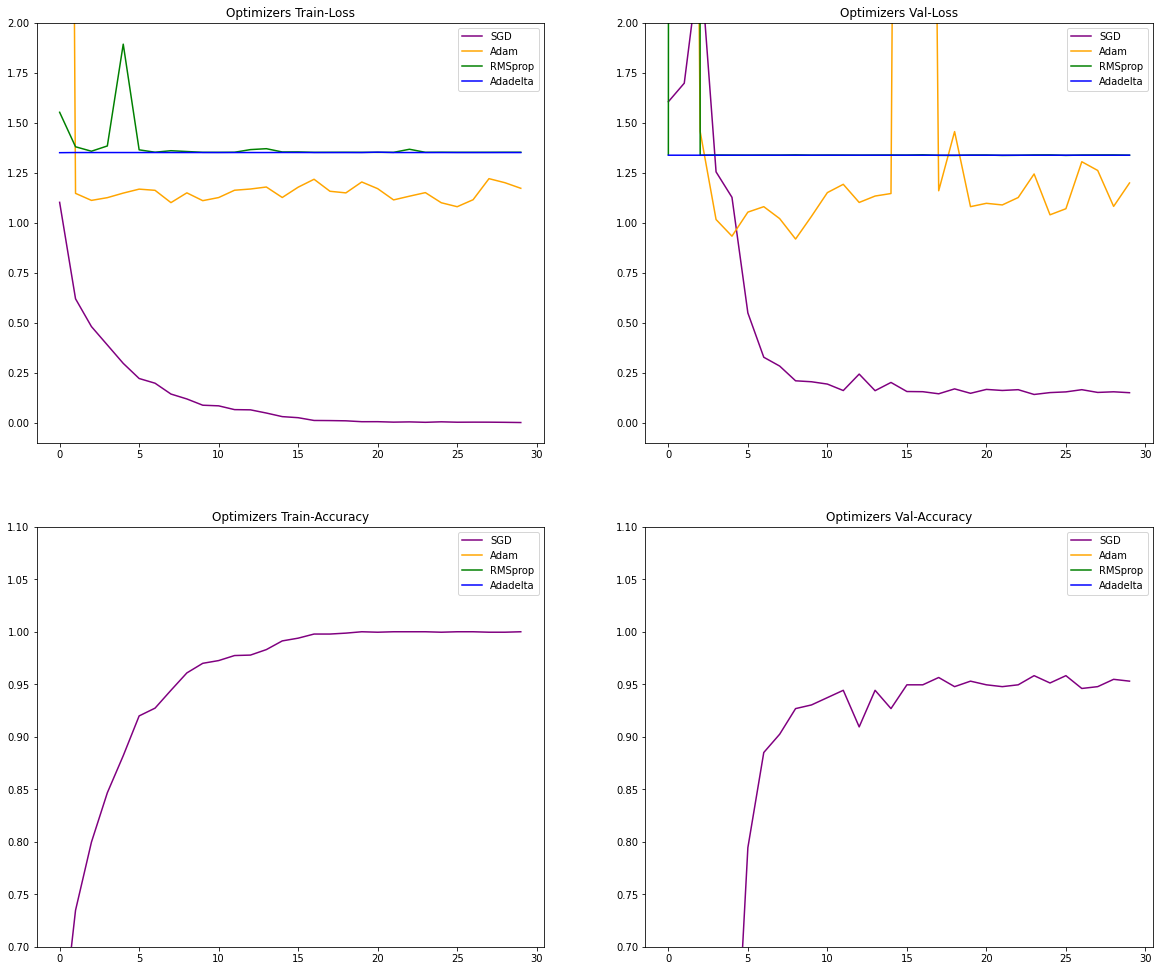

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20,17))

axs[0, 0].plot(history3.history["loss"],c = "purple")
axs[0, 0].plot(history9.history["loss"],c = "orange")
axs[0, 0].plot(history10.history["loss"],c = "green")
axs[0, 0].plot(history11.history["loss"],c = "blue")
axs[0, 0].set_ylim([-0.1,2])
axs[0, 0].legend(["SGD", "Adam", "RMSprop", "Adadelta"])
axs[0, 0].set_title('Optimizers Train-Loss')

axs[0, 1].plot(history3.history["val_loss"],c = "purple")
axs[0, 1].plot(history9.history["val_loss"],c = "orange")
axs[0, 1].plot(history10.history["val_loss"],c = "green")
axs[0, 1].plot(history11.history["val_loss"],c = "blue")
axs[0, 1].set_ylim([-0.1,2])
axs[0, 1].legend(["SGD", "Adam", "RMSprop", "Adadelta"])
axs[0, 1].set_title('Optimizers Val-Loss')

axs[1, 0].plot(history3.history["accuracy"],c = "purple")
axs[1, 0].plot(history9.history["accuracy"],c = "orange")
axs[1, 0].plot(history10.history["accuracy"],c = "green")
axs[1, 0].plot(history11.history["accuracy"],c = "blue")
axs[1, 0].set_ylim([0.7,1.1])
axs[1, 0].legend(["SGD", "Adam", "RMSprop", "Adadelta"])
axs[1, 0].set_title('Optimizers Train-Accuracy')

axs[1, 1].plot(history3.history["val_accuracy"],c = "purple")
axs[1, 1].plot(history9.history["val_accuracy"],c = "orange")
axs[1, 1].plot(history10.history["val_accuracy"],c = "green")
axs[1, 1].plot(history11.history["val_accuracy"],c = "blue")
axs[1, 1].set_ylim([0.7,1.1])
axs[1, 1].legend(["SGD", "Adam", "RMSprop", "Adadelta"])
axs[1, 1].set_title('Optimizers Val-Accuracy')

**Insights:**  In the figure above we can see how SGD performed without a doubt as the best one in the four plots, the three other optimizers didn't even have an accuracy over 70%!, RMSprop and Adadelta seems unuseful for this data and Adam had too much transitories and does not reduce significantly in loss nor increase accuracy.  
**Note:** I am novice in Deep Learning and thus when I was doing the 1st comparation I used Adam as optimizer and got horrible results, spent more than 2 days finding the reason and finally tried SGD and it works astonishingly, as recommendation when you are doing modeling by scratch and if you get bad performance always change the optimizer! Adam is hugely used, but as everything it depends on your data, there are at least 8 types which can be suit.

## Best model: 

The best model built had the following characteristics:  
(By default our model contains 6 Convolutional, 6 Max-pooling and 3 Fully-conected layers).  
    - Kernels size 7x7.  
    - Regularization using Batch Normalization after each Convolutional layers and Dropout after each Fully conected layer.  
    - Batch size = 32.  
    - Number of epochs = 30.  
    - Gradient Descent Optimizer: SGD.

In [42]:
model_x = load_model('my_model.h5')

In [43]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 200, 200, 64)      3200      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 100, 128)     401536    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 50, 50, 128)       0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 50, 50, 128)       512       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 50, 128)      

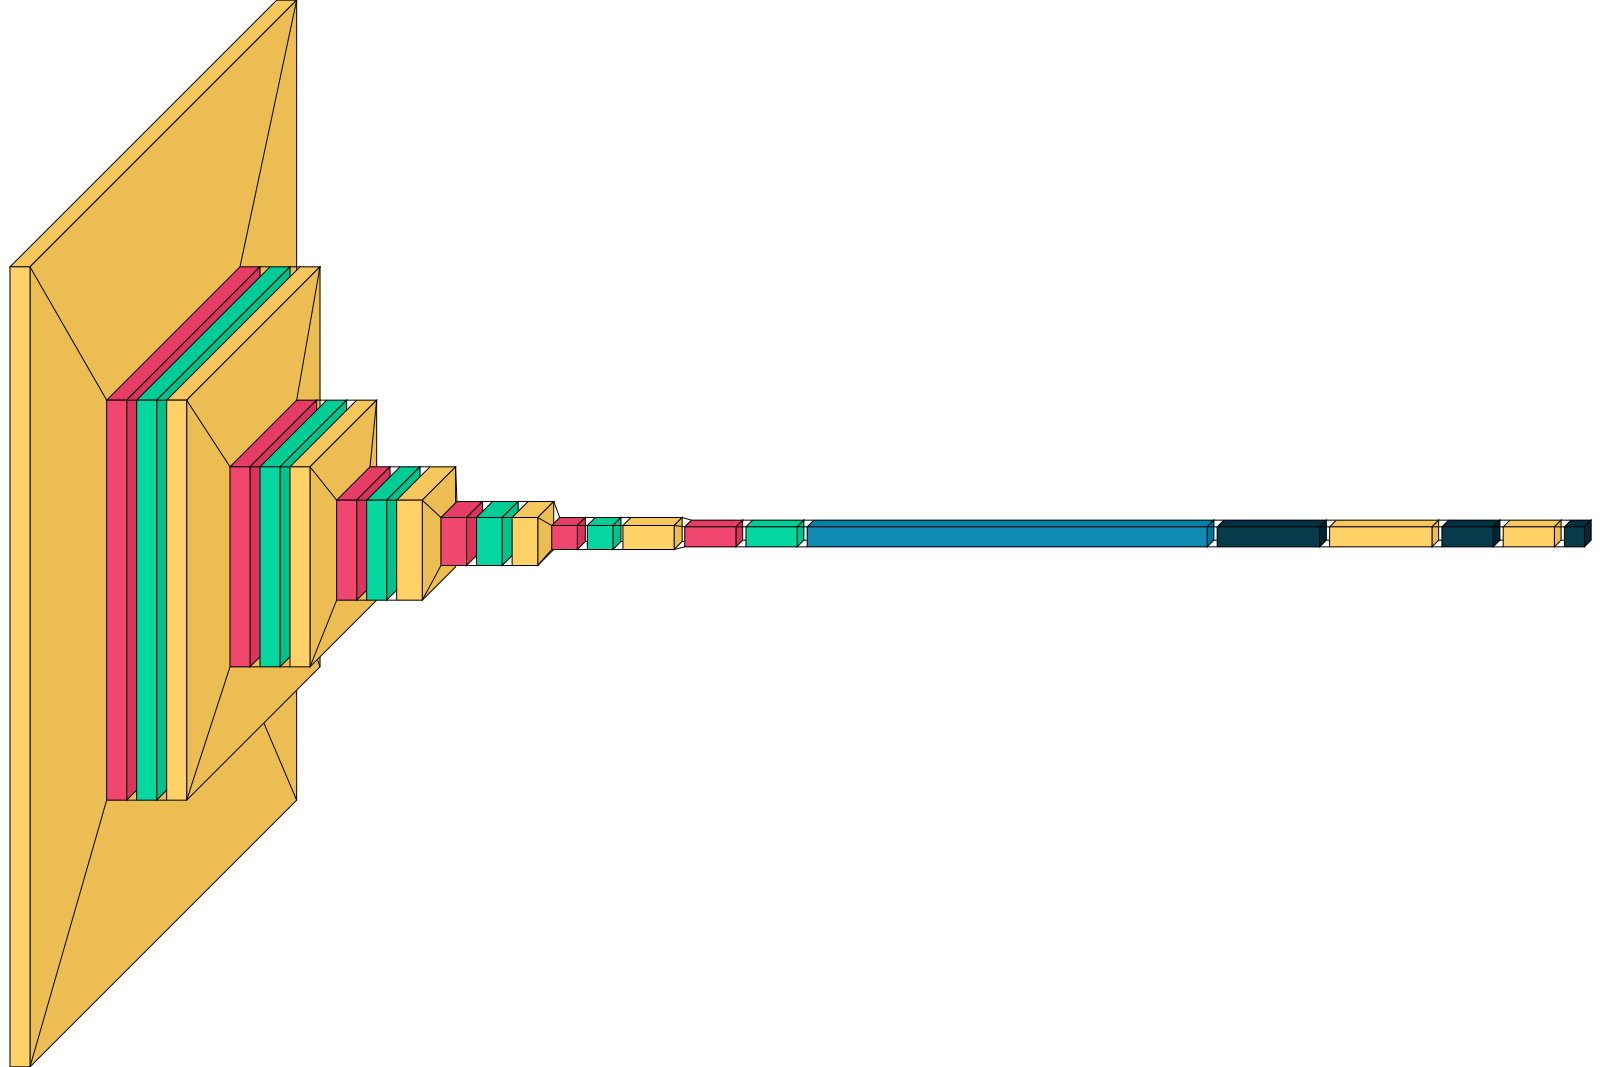

In [44]:
visualkeras.layered_view(model3)

## Performance on validation dataset:

In [45]:
X_val.shape, y_val.shape

((574, 200, 200, 1), (574, 4))

Predict the classes for x-validation set:

In [46]:
y_pred = model_x.predict(X_val)
print(y_pred[:5])

[[9.9988222e-01 5.7569952e-05 3.4686093e-06 5.6700384e-05]
 [4.9795392e-05 1.3335039e-06 8.9100067e-05 9.9985969e-01]
 [9.9964845e-01 3.1360605e-04 5.2620649e-06 3.2685944e-05]
 [1.7877771e-01 8.2066166e-01 6.7865808e-06 5.5392203e-04]
 [2.3450525e-07 3.8507656e-05 1.5771153e-07 9.9996114e-01]]


In [47]:
class_pred = [np.argmax(i) for i in y_pred]
print(class_pred[:5])

[0, 3, 0, 1, 3]


Printing the original classes for the 5 first records:

In [48]:
val_labels =[np.argmax(i) for i in y_val]
print(val_labels[:5])

[0, 3, 0, 0, 3]


Classification report for the validation dataset:

In [49]:
from sklearn.metrics import classification_report

report = classification_report(val_labels, class_pred)

print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       179
           1       0.93      0.95      0.94       169
           2       0.95      0.87      0.91        70
           3       0.96      0.99      0.97       156

    accuracy                           0.95       574
   macro avg       0.95      0.94      0.95       574
weighted avg       0.95      0.95      0.95       574



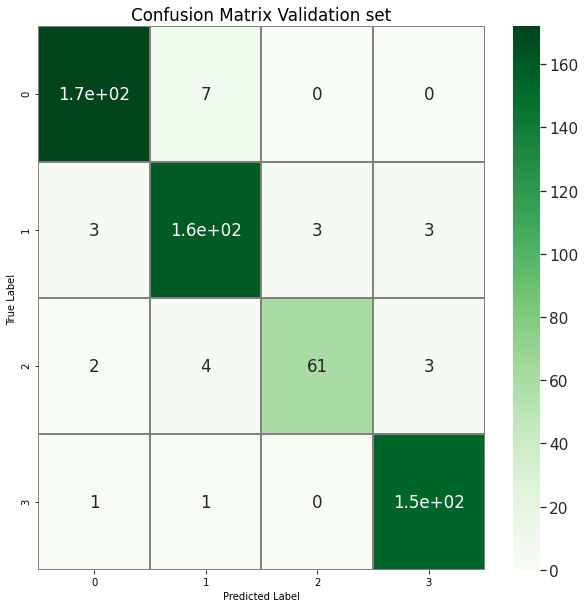

In [50]:
from sklearn.metrics import confusion_matrix

f,ax = plt.subplots(figsize=(10, 10))
confusion_mtx = confusion_matrix(val_labels, class_pred)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Validation set")
plt.show()

## Performance on testing dataset:

In [51]:
data_dir_test=(r'/kaggle/input/brain-tumor-classification-mri/Testing/')

Defining x_test and y_test:

In [52]:
x_test=[]
y_test=[]

for i in categories:
    test_path = os.path.join(data_dir_test,i)
    for j in os.listdir(test_path):
        img = cv2.imread(os.path.join(test_path,j),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(new_size,new_size))
        x_test.append(img)
        y_test.append(i)

Convert to numpy array and reshape both x_test and y_test:

In [53]:
x_test=np.array(x_test)
x_test=x_test/255.0
x_test=x_test.reshape(-1,new_size,new_size,1)
x_test.shape

(394, 200, 200, 1)

In [54]:
y_test=np.array(y_test)
y_test.shape

(394,)

In [55]:
y_test_new = []
for i in y_test:
    y_test_new.append(categories.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Predict the class of images in x_test:

In [56]:
predicted_labels = model_x.predict(x_test)
print(predicted_labels[:5])

[[3.5541750e-06 9.9232543e-01 7.6698735e-03 1.1972604e-06]
 [7.2589555e-06 1.9110210e-01 8.0884463e-01 4.6024466e-05]
 [2.2966599e-06 2.1273558e-01 7.8726131e-01 7.5888647e-07]
 [1.2717271e-07 9.9950445e-01 4.9243332e-04 3.0252152e-06]
 [4.0912395e-03 9.3546671e-01 6.0384467e-02 5.7649686e-05]]


Get the index (label) of the class predicted:

In [57]:
predicted_labels = [np.argmax(i) for i in predicted_labels]
print(predicted_labels[:5])

[1, 2, 2, 1, 1]


Compare with the original labels:

In [58]:
original_labels =[np.argmax(i) for i in y_test]
print(original_labels[:5])

[0, 0, 0, 0, 0]


Finally plot the classification report and confusion matrix for testing dataset: 

In [59]:
report2 = classification_report(original_labels, predicted_labels)

print(report2)

              precision    recall  f1-score   support

           0       1.00      0.18      0.31       100
           1       0.67      0.97      0.79       115
           2       0.68      0.99      0.81       105
           3       0.89      0.69      0.78        74

    accuracy                           0.72       394
   macro avg       0.81      0.71      0.67       394
weighted avg       0.80      0.72      0.67       394



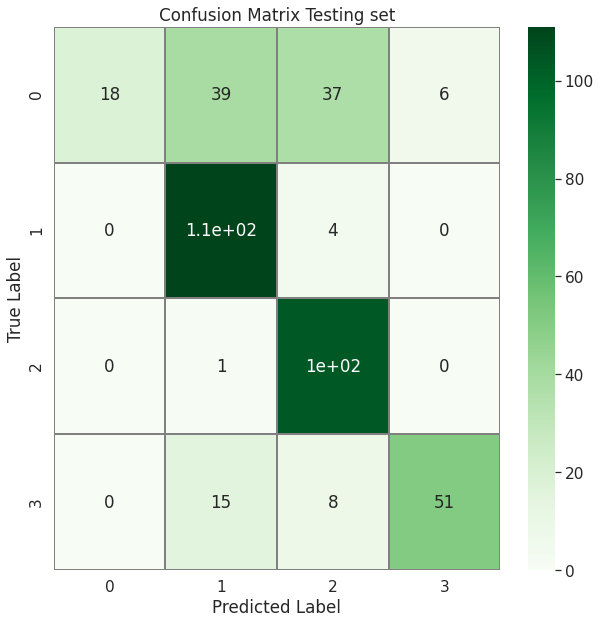

In [60]:
f,ax = plt.subplots(figsize=(10, 10))
confusion_mtx2 = confusion_matrix(original_labels, predicted_labels)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx2, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Testing set")
plt.show()